In [1]:
import numpy as np
from matplotlib import pyplot as plt
import datetime
import ooi_data_processing_library as ooilib

In [2]:
# get 5 minutes of acoustic data from OOI server
start_time = datetime.datetime(2016,10,6,0,0,0) # time of first sample
end_time = datetime.datetime(2016,10,6,0,5,0) # time of last sample
acoustic_data = ooilib.get_acoustic_data(start_time, end_time, node='/PC01A')

C:\Users\fschwock\AppData\Local\Continuum\anaconda3\envs\obspy\lib\site-packages\obspy\core\utcdatetime.py:1271: ObsPyDeprecationWarning: Setting attributes on UTCDateTime instances will raise an Exception in a future version of Obspy.
  warnings.warn(msg, ObsPyDeprecationWarning)


In [3]:
# acoustic_data is obspy Stream
print('type: ', type(acoustic_data), '\n')
print('acoustic data: ', acoustic_data, '\n')
print('stats: ', acoustic_data[0].stats, '\n')
print('data: ', acoustic_data[0].data, '\n')

type:  <class 'obspy.core.stream.Stream'> 

acoustic data:  1 Trace(s) in Stream:
OO.HYVM2..YDH | 2016-10-06T00:00:00.000000Z - 2016-10-06T00:04:59.995109Z | 64000.0 Hz, 19199688 samples 

stats:           network: OO
         station: HYVM2
        location: 
         channel: YDH
       starttime: 2016-10-06T00:00:00.000000Z
         endtime: 2016-10-06T00:04:59.995109Z
   sampling_rate: 64000.0
           delta: 1.5625e-05
            npts: 19199688
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 4883, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 20000768})
      processing: ['ObsPy 1.2.1: trim(endtime=UTCDateTime(2016, 10, 6, 0, 5)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2016, 10, 6, 0, 0))', "ObsPy 1.2.1: filter(options={'freqmin': 20.0, 'freqmax': 30000.0}::type='bandpass')"] 

data:  [-18507.86804268 -27869.1132966  -20594.63217263 ...,   -149.167500

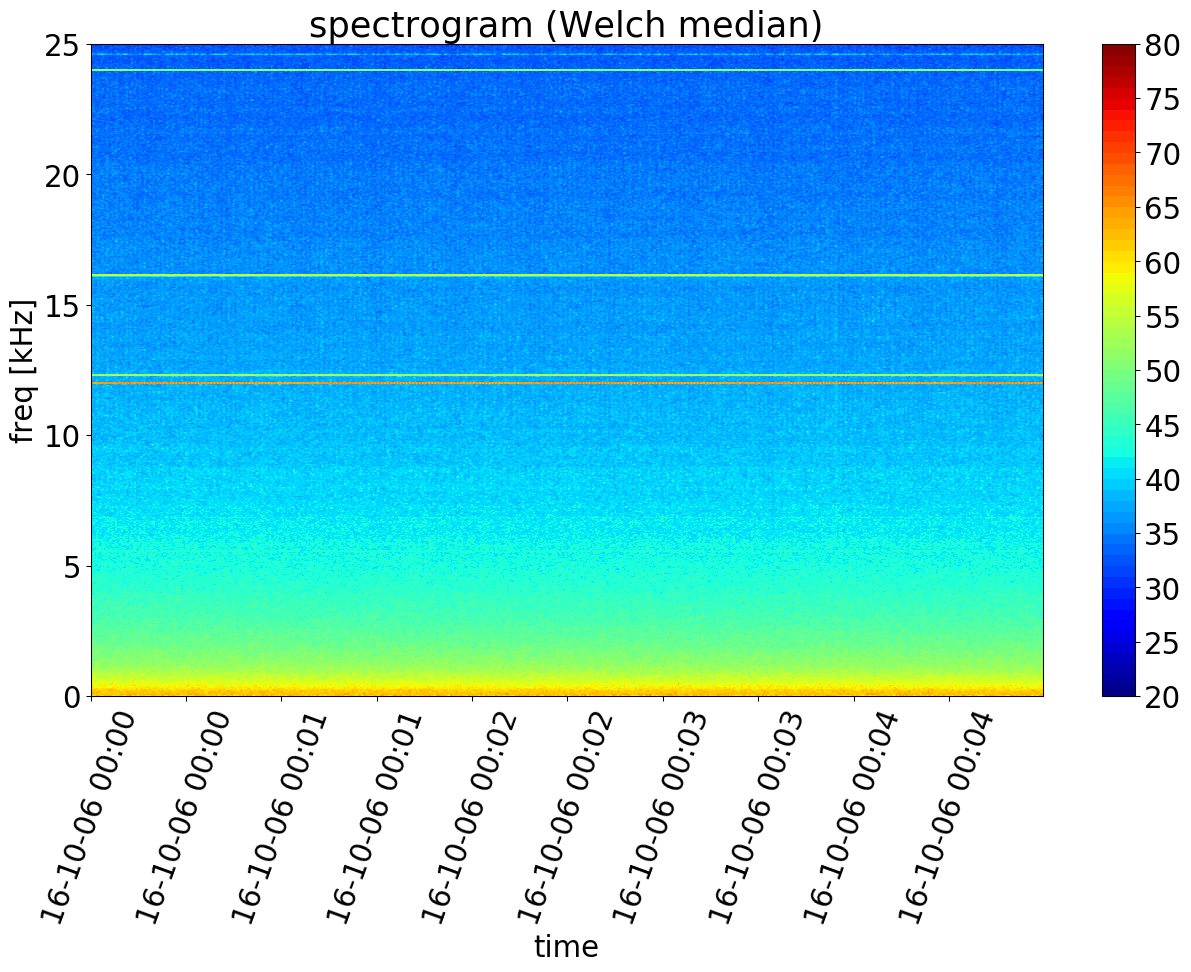

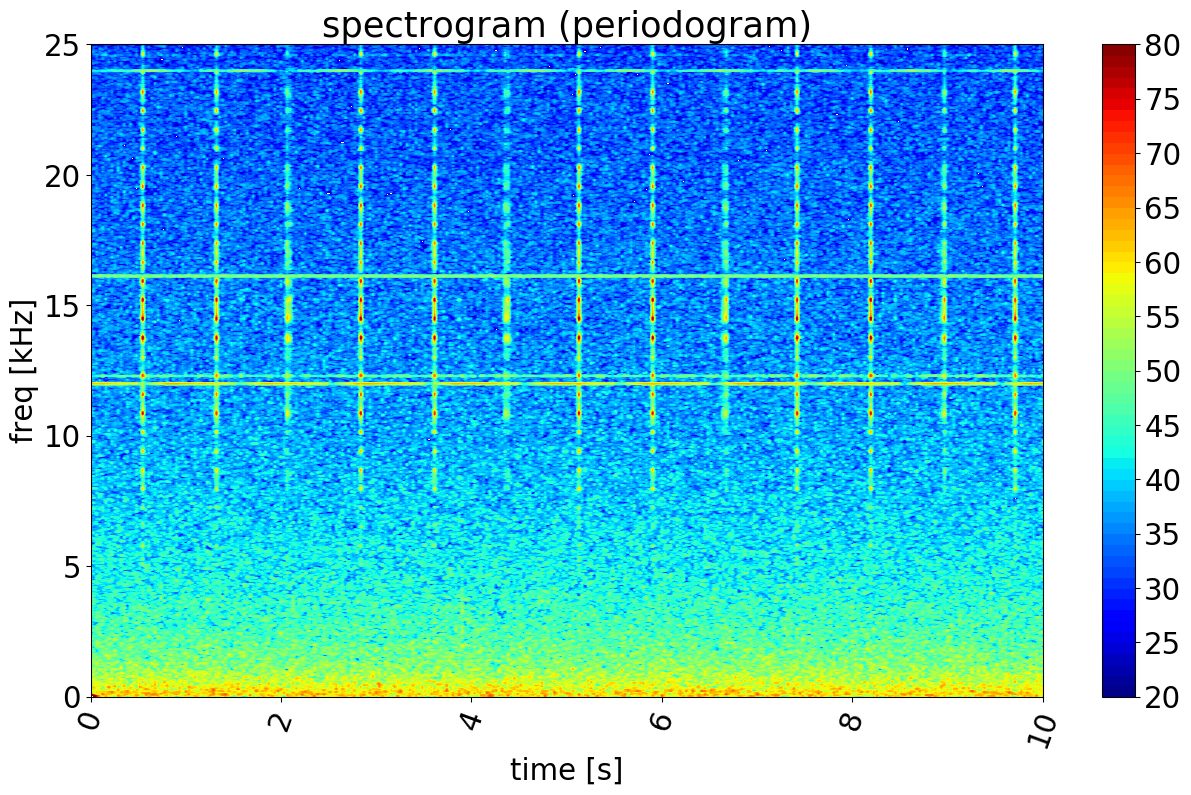

In [4]:
# compute and visualize spectrogram for noise data.

# 1. Welch median over a data segment of 0.5s is used to compute the spectrum at each bin
# of the spectrogram
t, f, spectrogram = ooilib.compute_spectrogram(start_time, end_time, node='/PC01A', avg_time=0.5)
ooilib.visualize_spectrogram(spectrogram, t=t, f=f/1000,title='spectrogram (Welch median)',
                             ylabel='freq [kHz]', fmin=0, fmax=25, vmin=20, vmax=80)

# 2. Periodogram estimate is used to compute the spectrum at each bin of the spectrogram
# To do so, the parameter avg_time is set to None (default). The amount of data are reduced to
# 10s to avoid memory overflow while plotting the data.
start_time2 = datetime.datetime(2016,10,6,0,0,0) # time of first sample
end_time2 = datetime.datetime(2016,10,6,0,0,10) # time of last sample
t, f, spectrogram = ooilib.compute_spectrogram(start_time2, end_time2, node='/PC01A', L=2048)
t = np.linspace(0, 10, len(spectrogram))
ooilib.visualize_spectrogram(spectrogram, t=t, f=f/1000, title='spectrogram (periodogram)',
                             ylabel='freq [kHz]', xlabel='time [s]', fmin=0, fmax=25, vmin=20, vmax=80)

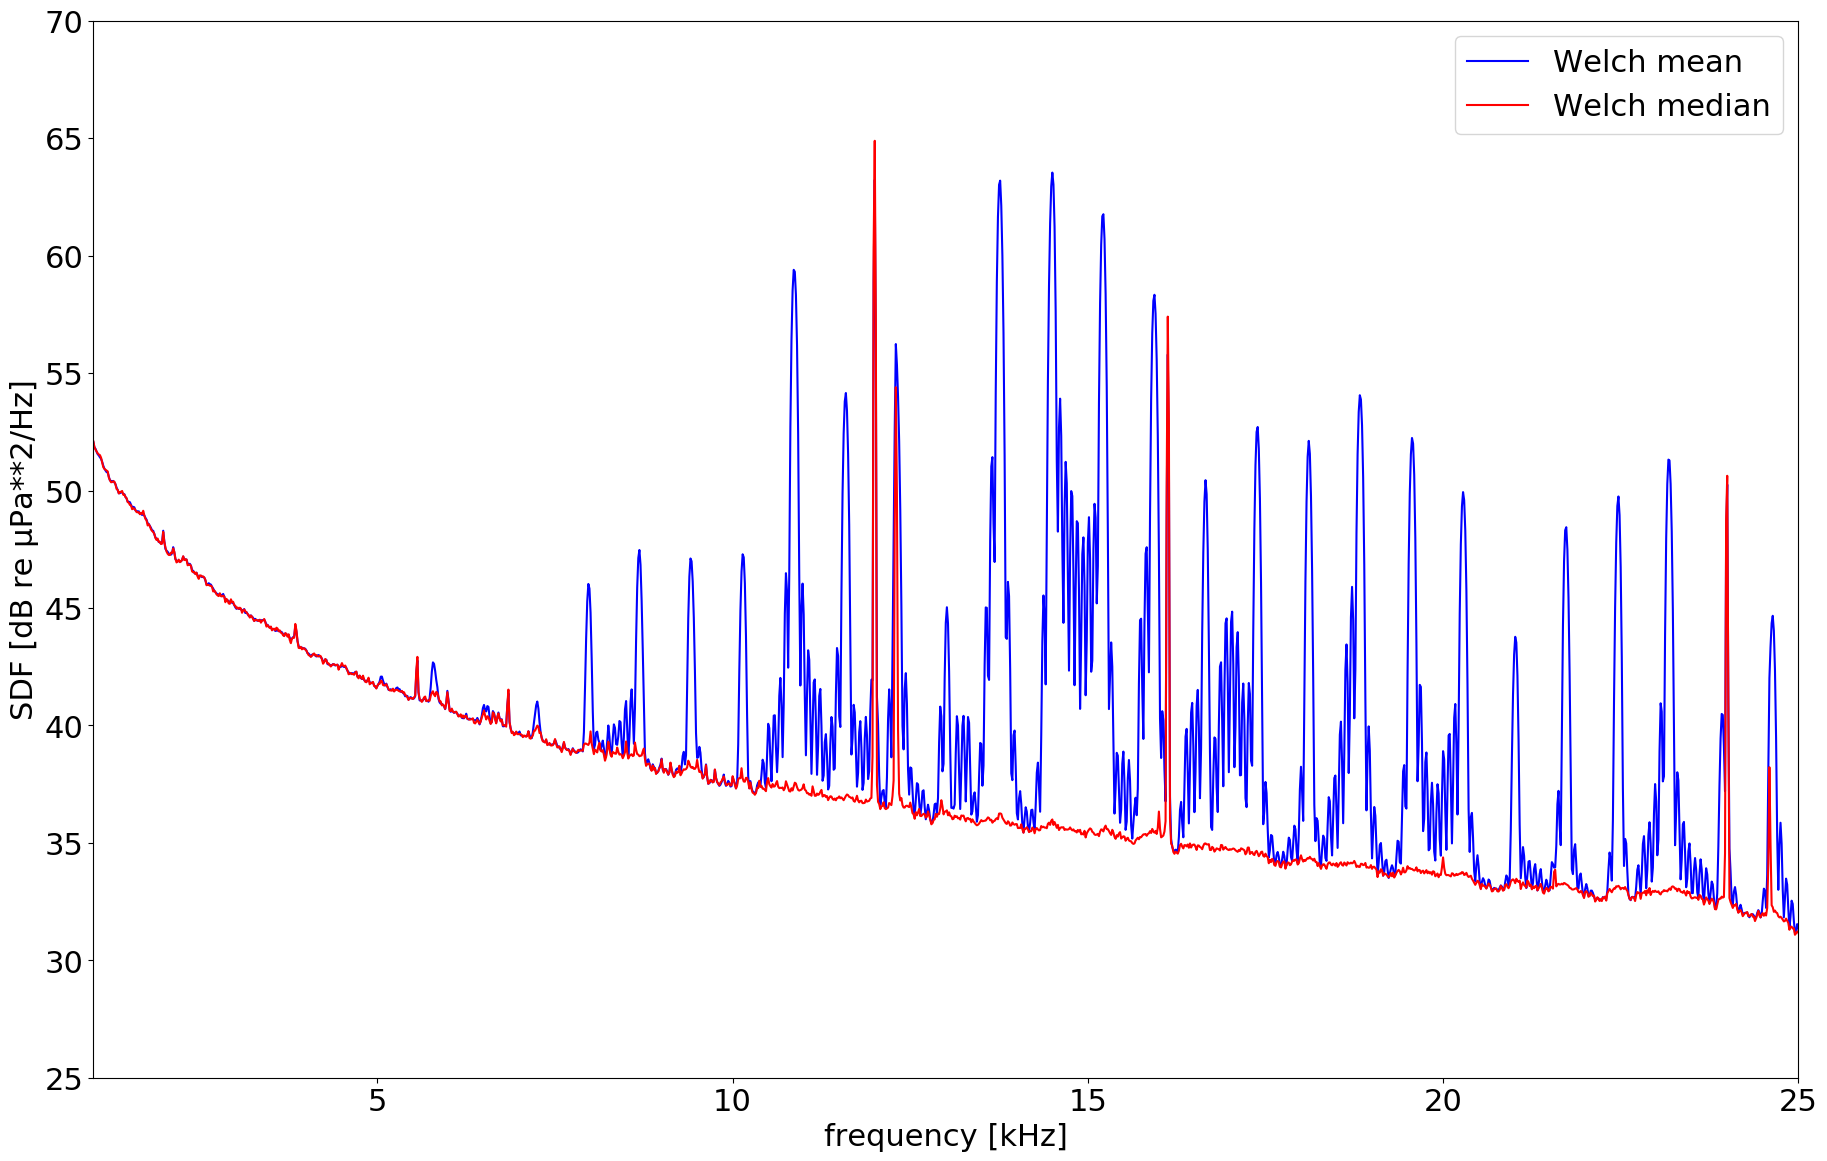

In [5]:
# power spectral density estimate of noise data using Welch's method
# 1. using median averaging (default)
f, psd_med = ooilib.compute_psd_welch(start_time, end_time, node='/PC01A')

# 2. using mean averaging
f, psd_mean = ooilib.compute_psd_welch(start_time, end_time, node='/PC01A', avg_method='mean')

fig, ax = plt.subplots(figsize=(22,14), dpi=100)
plt.plot(f/1000, psd_mean,label='Welch mean',color='b')
plt.plot(f/1000, psd_med,label='Welch median',color='r')
plt.xlabel('frequency [kHz]')
plt.ylabel('SDF [dB re µPa**2/Hz]')
plt.xlim(1,25)
plt.ylim(25,70)
plt.legend()

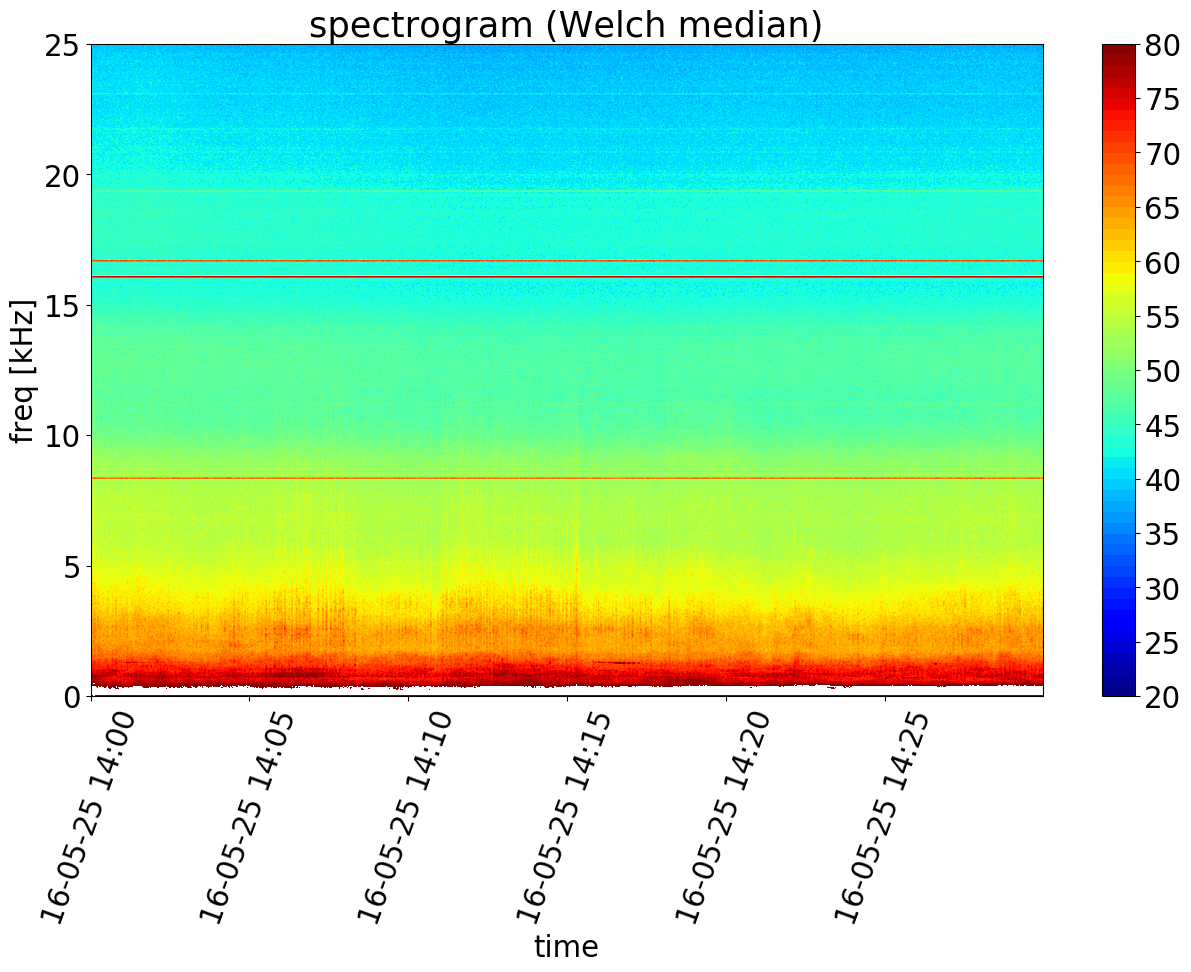

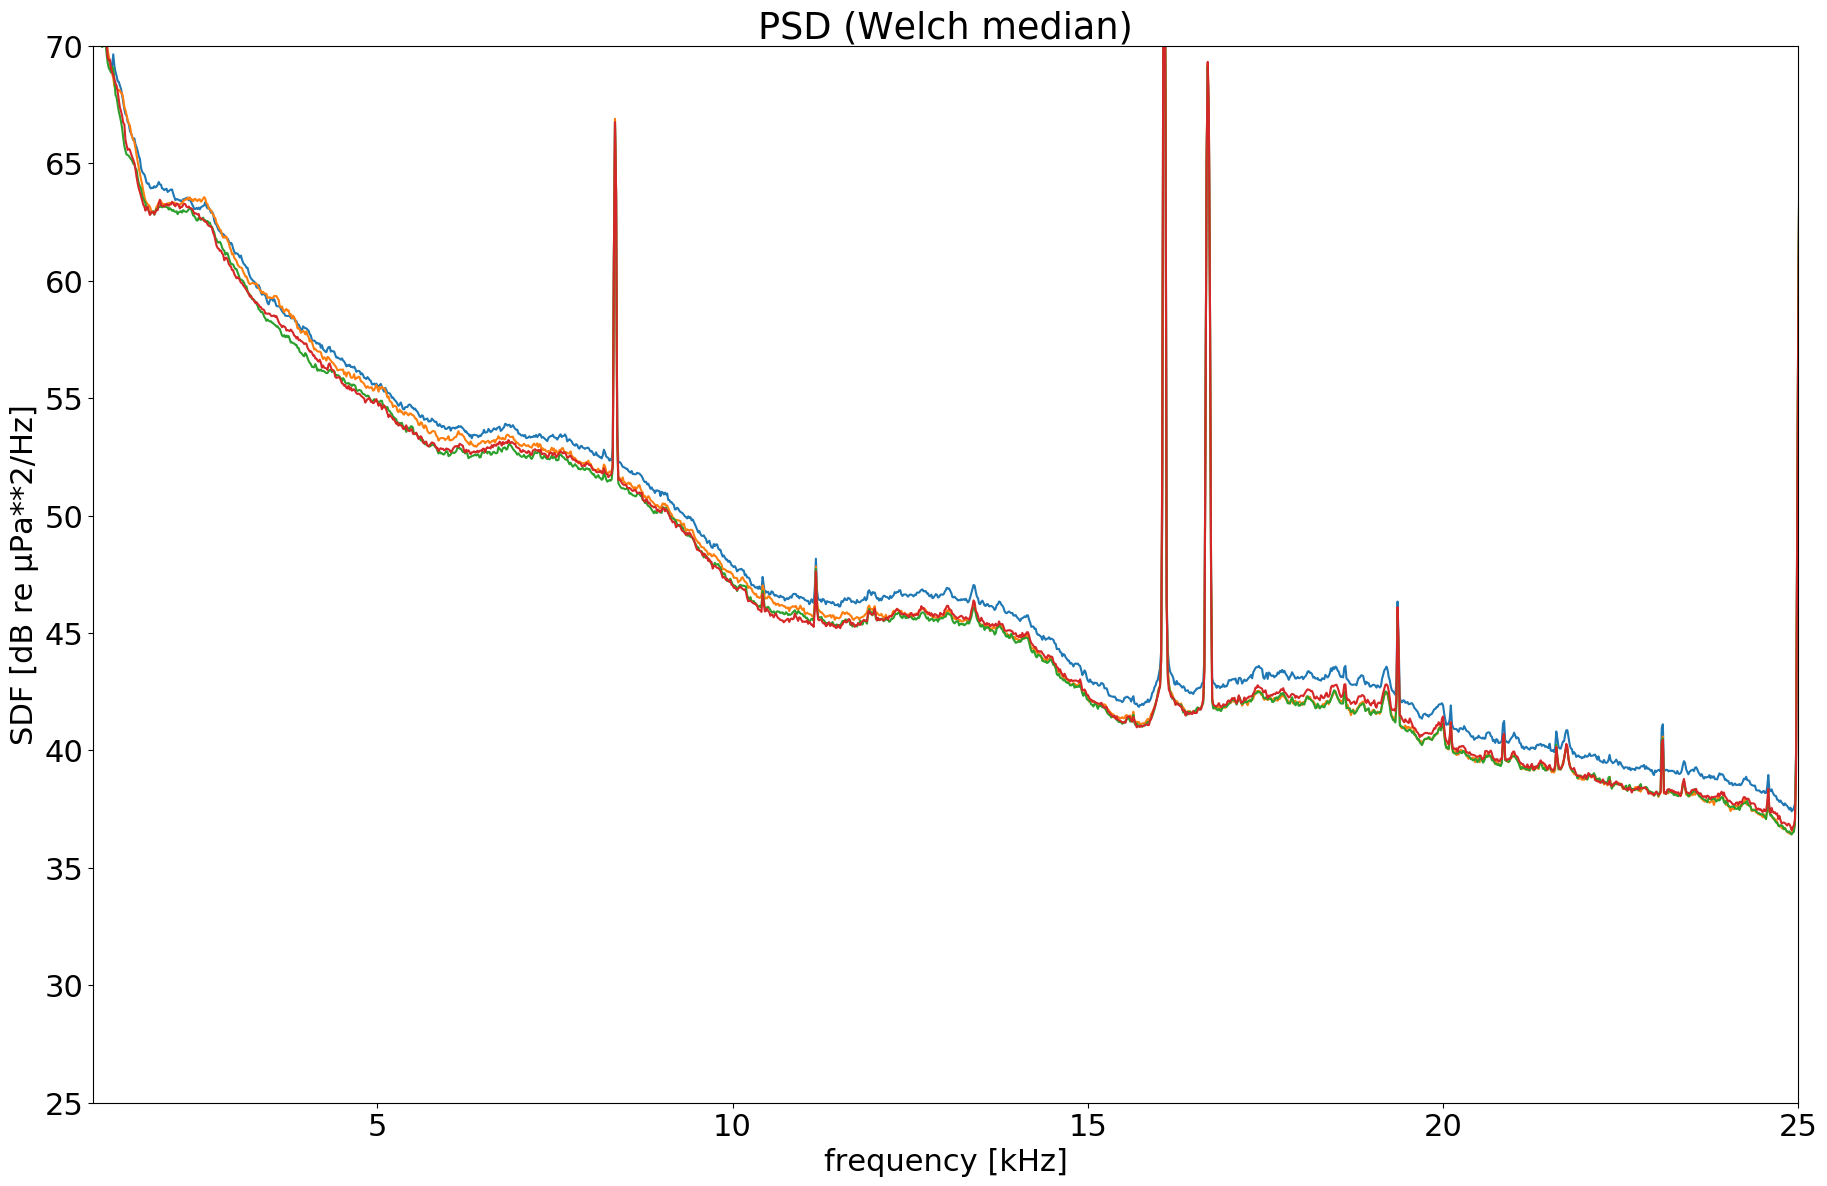

In [6]:
# multiprocessing functions when processing a large amount of data (here 30min).
# The third parameter in compute_spectrogram_mp() defined the lengths of the segments
# (in seconds) that are processed independently and in parallel by different subprocesses.
# The number of subprocesses used is the number of CPU cores (default) unless another value
# is specified by the parameter 'n_process'.

start_time3 = datetime.datetime(year=2016, month=5, day=25, hour=14, minute=0, second=0)
end_time3 = datetime.datetime(year=2016, month=5, day=25, hour=14, minute=30, second=0)

# spectrogram
t, f, spectrogram = ooilib.compute_spectrogram_mp(start_time3, end_time3, 60, node='/LJ01C', avg_time=1)
ooilib.visualize_spectrogram(spectrogram, t=t, f=f/1000, title='spectrogram (Welch median)',
                             ylabel='freq [kHz]', fmin=0, fmax=25, vmin=20, vmax=80)

# PSD
# Here, each segment has a length of 900s. For each segment a separate PSD estimate is 
# returned.
f, psds_med = ooilib.compute_psd_welch_mp(start_time3, end_time3, 450, node='/LJ01C')

fig, ax = plt.subplots(figsize=(22,14), dpi=100)
for psd in psds_med:
    plt.plot(f/1000, psd)
    
plt.xlabel('frequency [kHz]')
plt.ylabel('SDF [dB re µPa**2/Hz]')
plt.title('PSD (Welch median)')
plt.xlim(1,25)
plt.ylim(25,70)
plt.show()